# Большая домашка 1: классификация отзывов

## Данные

Скачиваются по [ссылке](https://drive.google.com/open?id=1gJEpwM3zdV5xe9nRU0VwQmGTiOTQdp10). Это отзывы пользователей на фильмы с КиноПоиска.

In [1]:
import os
from time import time
from collections import Counter

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv(os.path.join('data', 'reviews.csv'))

In [3]:
df.head()

,label,text
0,1,Эпиграф Добро которое ты делаешь от сердца ты ...
1,1,Теперь это один из моих любимых фильмов в жанр...
2,1,Что скрыто в фильме Лучше не бывает Одна шикар...
3,1,Перед нами очень милое и доброе кино которое л...
4,1,Завязка Мелвин Удал популярный писатель Нет не...


In [4]:
set(df.label)

{-1, 0, 1}

В колонке `label` три класса: положительный (1), нейтральный (0) и отрицательный (-1).

In [5]:
# Imbalanced dataset: 2 rare classes and 1 majority class
df.label.value_counts()

 1    36480
 0     5645
-1     4376
Name: label, dtype: int64

## Baseline

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
vec = CountVectorizer()
bag_of_words = vec.fit_transform(df.text)
print('# of reviews: {:,}\n# of features: {:,}'.format(*bag_of_words.shape))
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df.label, random_state=42)

# of reviews: 46,501
# of features: 369,844


In [8]:
nb = MultinomialNB()
clf = nb.fit(X_train, y_train)

In [9]:
from sklearn.metrics import classification_report

In [10]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.76      0.21      0.33      1075
           0       0.35      0.08      0.13      1410
           1       0.82      0.98      0.89      9141

    accuracy                           0.80     11626
   macro avg       0.64      0.42      0.45     11626
weighted avg       0.75      0.80      0.75     11626



## Задание

Побейте baseline выше как минимум тремя способами.


**Обязательно**:
* попробовать разный препроцессинг (2 балла)
* попробовать разные классификаторы (2 балла)
* поподбирать гиперпараметры классификаторов, можно с использованием GridSearch (2 балла)
* попробуйте объяснить полученные результаты (2 балла)
* визуализируйте веса признаков для лучшей модели (если лучшая модель не выдаёт коэффициенты признаков, возьмите логистическую регрессию); какие признаки оказались самыми значимыми? (2 балла)

Если вы перебрали уже много разных способов и выполнили все обязательные критерии, но побить baseline тремя способами так и не получилось, не беспокойтесь. Главное -- полнота попыток :)

Good luck and have fun! ;)

In [11]:
# save Baseline MNB model predictions for comparision
predictions_df = pd.DataFrame()
predictions_df['MNB_BL'] = clf.predict(X_test)
# predictions_df.to_csv(os.path.join('data', 'predictions.csv'), index=False)

## MultinomialNB со стеммингом

### Стемминг

In [12]:
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords

stemmer = RussianStemmer()

def my_stemmer(text):
    """Return stemmed text as string."""
    stemmed_words = [stemmer.stem(word) for word in text.split(' ')]
    return ' '.join(stemmed_words)


print(my_stemmer('Эпиграф Добро которое ты делаешь от сердца т'))
print(df['text'][:2].map(my_stemmer))

эпиграф добр котор ты дела от сердц т
0    эпиграф добр котор ты дела от сердц ты дела вс...
1    тепер эт один из мо любим фильм в жанр в жанр ...
Name: text, dtype: object


```
# Stem text  -- TAKES LONG. WAIT!
t0 = time()
df['text_clean'] = df['text'].map(my_stemmer)
print(f'Done in {time() - t0} seconds')
```

```
Output:
Done in 1310.778491973877 seconds

```

```
# Save new df to file
df.to_csv(os.path.join('data', 'reviews_clean.csv'), encoding='utf8', index=False)
```

### Обучение Multinomial Naive Bayes на данных со стеммингом

[Тьюториал sklearn по работе с текстами](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Стемминг текстов позволяет примерно вдвое увеличить recall и f1-score по редким классам 

In [13]:
# Load new df from file
df = pd.read_csv(os.path.join('data', 'reviews_clean.csv'))
df.head()

,label,text,text_clean
0,1,Эпиграф Добро которое ты делаешь от сердца ты ...,эпиграф добр котор ты дела от сердц ты дела вс...
1,1,Теперь это один из моих любимых фильмов в жанр...,тепер эт один из мо любим фильм в жанр в жанр ...
2,1,Что скрыто в фильме Лучше не бывает Одна шикар...,что скрыт в фильм лучш не быва одн шикарн мысл...
3,1,Перед нами очень милое и доброе кино которое л...,перед нам очен мил и добр кин котор личн я смо...
4,1,Завязка Мелвин Удал популярный писатель Нет не...,завязк мелвин уда популярн писател нет не так ...


In [14]:
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(df.text_clean, df.label, random_state=42)

# Build a pipeline (vectorizer => classifier) 
text_clf = Pipeline([
    ('vect', CountVectorizer()),  # use 'vect' and 'clf'
    ('clf', MultinomialNB()),     # to perform grid search for suitable hyperparameters
])

# Train
t0 = time()
text_clf.fit(X_train, y_train)
print(f'Done in {time() - t0} seconds')

Done in 10.645115852355957 seconds


In [15]:
# Predict
pred = text_clf.predict(X_test)

# save predictions to DataFrame
predictions_df['MNB_stem'] = pred

# # save to file
# predictions_df.to_csv(os.path.join('data', 'predictions.csv'), index=False)

In [16]:
# Compare with Baseline
print('Baseline NB:\n')
print(classification_report(y_test, predictions_df.MNB_BL))
print('-' * 55)
print('NB with word stemming:\n')
print(classification_report(y_test, predictions_df.MNB_stem))

Baseline NB:

              precision    recall  f1-score   support

          -1       0.76      0.21      0.33      1075
           0       0.35      0.08      0.13      1410
           1       0.82      0.98      0.89      9141

    accuracy                           0.80     11626
   macro avg       0.64      0.42      0.45     11626
weighted avg       0.75      0.80      0.75     11626

-------------------------------------------------------
NB with word stemming:

              precision    recall  f1-score   support

          -1       0.62      0.54      0.58      1075
           0       0.35      0.23      0.28      1410
           1       0.88      0.94      0.91      9141

    accuracy                           0.82     11626
   macro avg       0.62      0.57      0.59     11626
weighted avg       0.79      0.82      0.80     11626



In [17]:
print('support means true y-values in the test set')
print(Counter(y_test))

support means true y-values in the test set
Counter({1: 9141, 0: 1410, -1: 1075})


### Визуализация с помощью Confusion Matrix

Модель Baseline MNB -vs- модель MNB, обученная на данных со стеммингом

In [18]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [19]:
def confusion_matrix(labels, predicted_labels, label_classes):
    """Return a dataframe with a sklearnconfusion matrix."""
    return pd.DataFrame(
        sklearn.metrics.confusion_matrix(labels, predicted_labels),
        index=[label_classes], 
        columns=label_classes)

def print_heatmap(conf_matrix, title, labels):
    """Print a confusion matrix as a heat map, with labels from a list."""
    fig, ax = plt.subplots(figsize=(4,4)) 
    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    plt.xlabel('Actual labels')
    plt.ylabel('Predicted labels')
    plt.title(title)
    plt.show()

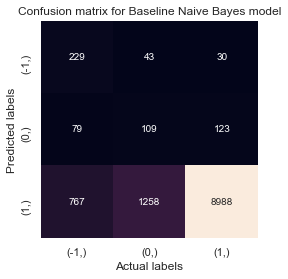

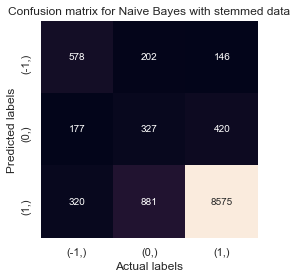

In [20]:
# confusion matrix for Baseline MNB
conf_matrix_BL = confusion_matrix(y_test,
                               predictions_df.MNB_BL,
                               sorted(df.label.unique()))


# confusion matrix for MNB trained on stemmed texts
conf_matrix_stem = confusion_matrix(y_test,
                               predictions_df.MNB_stem,
                               sorted(df.label.unique()))

print_heatmap(conf_matrix_BL.T,
              'Confusion matrix for Baseline Naive Bayes model',
              conf_matrix_BL.index)

print_heatmap(conf_matrix_stem.T,
              'Confusion matrix for Naive Bayes with stemmed data',
              conf_matrix_stem.index)

### GridSearch для Multinomial NB

GridSearch ничего мне не дал. Работает долго, на сабсетах данных возвращает либо дефолтные параметры, либо такие, с которыми классификатор совсем не определяет редкие классы

```
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords

stemmed_stopwords = list(map(my_stemmer, stopwords.words('russian')))

t0 = time()
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(df.text_clean,
                                                    df.label,
                                                    random_state=42)  

# Build a pipeline (vectorizer => classifier) 
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],  # vect for CountVectorizer()
    'vect__stop_words': [None, stemmed_stopwords],
    'vect__max_df': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__alpha': (1, 2, 3, 4),             # clf for MultinomialNB()
}

gs_clf = GridSearchCV(text_clf,
                      parameters,
                      cv=5,
                      n_jobs=-1   # if several cores, use all
                     )

Search on a subset to speed up
gs_clf = gs_clf.fit(X_train[:4000], y_train[:4000])

print(f'Done in {time() - t0} seconds')

gs_clf.best_params_
```

## LogisticRegression c GridSearch на данных со стеммингом 

Логистическая регрессия с дефолтными параметрами дает более высокие значения recall и f1-score для двух редких классов по сравнению с Baseline. Подбор параметров с помощью ограниченного GridSearch позволяет еще немного улучшить эти метрики

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(df.text_clean, df.label, random_state=42)

# Build a pipeline (vectorizer => transformer => classifier) 
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('transf', TfidfTransformer()),
    ('clf', LogisticRegression(
        C=5,
        class_weight='balanced',
        max_iter=1000,
        random_state=42)
    ),
])
t0 = time()
# Train
text_clf.fit(X_train, y_train)

print(f'Done in {time() - t0} seconds')

Done in 69.4740138053894 seconds


In [22]:
# Predict
pred = text_clf.predict(X_test)

# Save predictions to DataFrame
predictions_df['LogRegTfIDF'] = pred

# Save to file
# predictions_df.to_csv(os.path.join('data', 'predictions.csv'), index=False)

In [23]:
# Compare with Baseline
print('Baseline NB:\n')
print(classification_report(y_test, predictions_df.MNB_BL))
print('-' * 55)
print('Logistic Regression trained on stemmed and TfIDF-vectorized texts:\n')
print(classification_report(y_test, predictions_df.LogRegTfIDF))

Baseline NB:

              precision    recall  f1-score   support

          -1       0.76      0.21      0.33      1075
           0       0.35      0.08      0.13      1410
           1       0.82      0.98      0.89      9141

    accuracy                           0.80     11626
   macro avg       0.64      0.42      0.45     11626
weighted avg       0.75      0.80      0.75     11626

-------------------------------------------------------
Logistic Regression trained on stemmed and TfIDF-vectorized texts:

              precision    recall  f1-score   support

          -1       0.58      0.66      0.62      1075
           0       0.32      0.41      0.36      1410
           1       0.92      0.87      0.90      9141

    accuracy                           0.79     11626
   macro avg       0.61      0.65      0.62     11626
weighted avg       0.82      0.79      0.80     11626



Вот так отчет по логистической регрессии выглядел до GridSearch:

```
Logistic Regression before GridSearch:

              precision    recall  f1-score   support

          -1       0.72      0.51      0.59      1075
           0       0.48      0.15      0.23      1410
           1       0.86      0.98      0.92      9141

    accuracy                           0.84     11626
   macro avg       0.69      0.55      0.58     11626
weighted avg       0.80      0.84      0.81     11626
```

### Небольшой GridSearch для Logistic Regression

```
from sklearn.model_selection import GridSearchCV

t0 = time()
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(df.text_clean,
                                                    df.label,
                                                    random_state=42)  

# Build a pipeline (vectorizer => classifier) 
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42)),
])

parameters = {
    'tfidf__use_idf': [True, False],
    'clf__C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
    'clf__class_weight': [None, 'balanced']
}

gs_clf = GridSearchCV(text_clf,
                      parameters,
                      cv=5,
                      n_jobs=-1
                     )

Search on a subset to speed up
gs_clf = gs_clf.fit(X_train[:4000], y_train[:4000])

print(f'Done in {time() - t0} seconds')

gs_clf.best_params_


# Output:

Done in 390.3925950527191 seconds

{'clf__C': 5, 'clf__class_weight': 'balanced', 'tfidf__use_idf': True}
```

## Визуализация весов признаков для логистической регрессии

In [24]:
# Get the classifier and vectorizer objects from the pipeline
clf = text_clf.named_steps['clf']
vectorizer = text_clf.named_steps['vect']

print('# of classes and # of features:', clf.coef_.shape)
print('Labels of classes:', clf.classes_)

# of classes and # of features: (3, 104574)
Labels of classes: [-1  0  1]


In [25]:
# Translation dict from vocab indexes to words
index_to_word = {
    ind: word
    for (word, ind)
    in vectorizer.vocabulary_.items()
    }

def get_features(class_label):
    """Return tuples of indexes and coef of features sorted from top to bottom by coef."""
    label_transl_dict = {-1: 0,
                        0: 1,
                        1: 2
                       }
    idx = label_transl_dict[class_label]
    return sorted(enumerate(clf.coef_[idx]), key=lambda pair: pair[1], reverse=True)

def get_words_from_idx(indexes):
    """Return a list of words from indexes."""
    return [index_to_word[index] for index in indexes]

def plot_top_features(class_label, max_top_feat):
    """Plot a bar chart of top features for a given label."""
    idx_coef_list = get_features(class_label=class_label)
    idx, coef = zip(*idx_coef_list)
    top_words = get_words_from_idx(idx[:max_top_feat])
    plt.figure(figsize=(12,4))
    plt.bar(top_words, coef[:max_top_feat])
    plt.title(f'Наиболее значимые признаки в категории {class_label}')
    plt.xlabel('Признаки')
    plt.ylabel('Коэффициенты')
    plt.xticks(rotation = '45')
    plt.show()

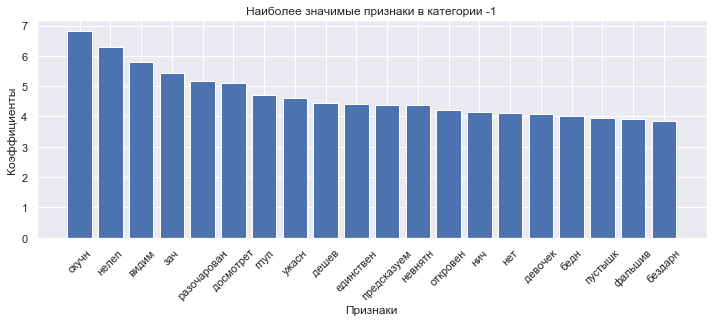

In [26]:
plot_top_features(class_label=-1, max_top_feat=20)

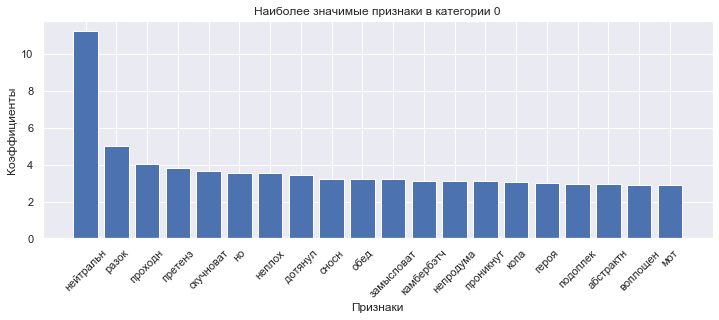

In [27]:
plot_top_features(class_label=0, max_top_feat=20)

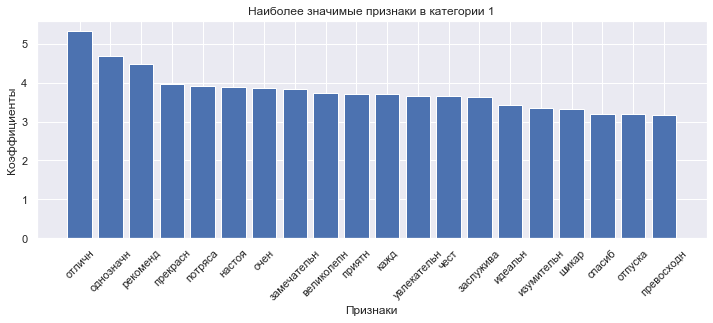

In [28]:
plot_top_features(class_label=1, max_top_feat=20)

## SVC - Support Vector Classification - на данных после стемминга и Tfidf-векторизации

Обучается безумно долго. Результаты при обучении с дефолтными параметрами сопоставимы с результатами Baseline NB. Я даже не буду пытаться менять параметры, не говоря уже о GridSearch  

```
from sklearn.svm import SVC

t0 = time()
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(df.text_clean, df.label, random_state=42)

# Build a pipeline (vectorizer => classifier) 
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('transf', TfidfTransformer()),
    ('clf', SVC()),
])

# Train
text_clf.fit(X_train, y_train)

print(f'Done in {time() - t0} seconds')

# Done in 8200.246840953827 seconds
```

```
# Predict
pred = text_clf.predict(X_test)

# save predictions to DataFrame
predictions_df['SVC'] = pred

# save to file
predictions_df.to_csv(os.path.join('data', 'predictions.csv'), index=False)
```

```
# Compare with Baseline
print('Baseline NB:\n')
print(classification_report(y_test, predictions_df.MNB_BL))
print('-' * 55)
print('SVC trained on stemmed and TfIDF-vectorized texts:\n')
print(classification_report(y_test, predictions_df.SVC))
```

```
Baseline NB:

              precision    recall  f1-score   support

          -1       0.76      0.21      0.33      1075
           0       0.35      0.08      0.13      1410
           1       0.82      0.98      0.89      9141

    accuracy                           0.80     11626
   macro avg       0.64      0.42      0.45     11626
weighted avg       0.75      0.80      0.75     11626

-------------------------------------------------------
SVC trained on stemmed and TfIDF-vectorized texts:

              precision    recall  f1-score   support

          -1       0.73      0.50      0.59      1075
           0       0.49      0.06      0.11      1410
           1       0.85      0.99      0.91      9141

    accuracy                           0.83     11626
   macro avg       0.69      0.52      0.54     11626
weighted avg       0.79      0.83      0.79     11626
```

## Классификатор Random Forest

Классификатор RF совсем не определяет редкие классы -- ни с дефолтными параметрами, ни с параметрами, найденными с помощью GridSearch на сабсете данных. Возможно, слишком много признаков и нужно использовать усовершенстованные версии этой модели (см. напр., обсуждение здесь: [stackexchange.com](https://stats.stackexchange.com/questions/343954/random-forest-short-text-classification)). Код для GridSearch для RandomForest в отдельном файле в репозитории -- rf_gridsearch.py

In [29]:
from sklearn.ensemble import RandomForestClassifier

t0 = time()
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(df.text_clean, df.label, random_state=42)

# Build a pipeline (vectorizer => transformer => classifier) 
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('transf', TfidfTransformer()),
    ('clf', RandomForestClassifier(
        n_estimators=5,
        max_depth=3,
        max_features=1,
        min_samples_leaf=1,
        min_samples_split=2,
        random_state=42)
    ),
])

# Train
text_clf.fit(X_train, y_train)

print(f'Done in {time() - t0} seconds')


Done in 14.005861043930054 seconds


In [30]:
# Predict
pred = text_clf.predict(X_test)

# save predictions to DataFrame
predictions_df['RF'] = pred

# save to file
# predictions_df.to_csv(os.path.join('data', 'predictions.csv'), index=False)

In [31]:
# Compare with Baseline
print('Baseline NB:\n')
print(classification_report(y_test, predictions_df.MNB_BL))
print('-' * 55)
print('RandomForest trained on stemmed and TfIDF-vectorized texts:\n')
print(classification_report(y_test, predictions_df.RF))

Baseline NB:

              precision    recall  f1-score   support

          -1       0.76      0.21      0.33      1075
           0       0.35      0.08      0.13      1410
           1       0.82      0.98      0.89      9141

    accuracy                           0.80     11626
   macro avg       0.64      0.42      0.45     11626
weighted avg       0.75      0.80      0.75     11626

-------------------------------------------------------
RandomForest trained on stemmed and TfIDF-vectorized texts:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1075
           0       0.00      0.00      0.00      1410
           1       0.79      1.00      0.88      9141

    accuracy                           0.79     11626
   macro avg       0.26      0.33      0.29     11626
weighted avg       0.62      0.79      0.69     11626



/Users/alexskrn/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Отчеты по всем моделям

In [32]:
for model_name, contents in predictions_df.iteritems():
    print(f'{model_name}:\n')
    print(classification_report(y_test, contents))
    print('-' * 55)

MNB_BL:

              precision    recall  f1-score   support

          -1       0.76      0.21      0.33      1075
           0       0.35      0.08      0.13      1410
           1       0.82      0.98      0.89      9141

    accuracy                           0.80     11626
   macro avg       0.64      0.42      0.45     11626
weighted avg       0.75      0.80      0.75     11626

-------------------------------------------------------
MNB_stem:

              precision    recall  f1-score   support

          -1       0.62      0.54      0.58      1075
           0       0.35      0.23      0.28      1410
           1       0.88      0.94      0.91      9141

    accuracy                           0.82     11626
   macro avg       0.62      0.57      0.59     11626
weighted avg       0.79      0.82      0.80     11626

-------------------------------------------------------
LogRegTfIDF:

              precision    recall  f1-score   support

          -1       0.58      0.66    

Самой адекватной выглядит модель логистической регрессии. Визуализация наиболее значимых признаков для этой модели приведена выше. Модель RandomForest не работает -- видимо, нужны более продвинутые версии этой модели.

### Бонус
(+2 балла к основному заданию; оценка за всё задание может быть выше 10)

Придумайте ещё 2-3 осмысленных способа визуализации данных или результатов. Добавьте их ниже или в текст основного задания. и сошлитесь на них здесь.

## ROC-кривая для многоклассовой классификации

Площадь под этой кривой показала бы, насколько хороша модель, и позволила бы сравнить модели. Но в многоклассовом случае код и графики становятся довольно замороченными. Отдельная сложность -- сделать такой график для классификатора NaiveBayes. Поэтому я адаптировал код из документации sklearn ([multi-lable ROC on scikit-learn.org](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)) только для своей логистической регрессии и на этом остановился. Я предполагаю, что можно было бы взять только "macro-average ROC curve" для всех моделей и наложить эти кривые на один график. Согласно документации "macro-averaging ... gives equal weight to the classification of each label", что, видимо, и нужно, так как в настоящем наборе данных есть два редких класса и не хотелось бы, чтобы мажоритарный класс перевешивал в оценке

In [33]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import interp
from sklearn.metrics import roc_auc_score

# data
X = df.text_clean
y = df.label

# Binarize the output
y = label_binarize(y, classes=[-1, 0, 1])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Learn to predict each class against the other
tfidf = TfidfVectorizer()
lg_clf = LogisticRegression(
        C=5,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
)
X_train = tfidf.fit_transform(X_train)

classifier = OneVsRestClassifier(lg_clf)
y_score = classifier.fit(X_train, y_train).decision_function(tfidf.transform(X_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

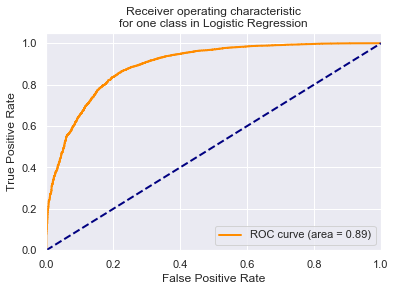

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic\nfor one class in Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### Кривые для всех классов

/Users/alexskrn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


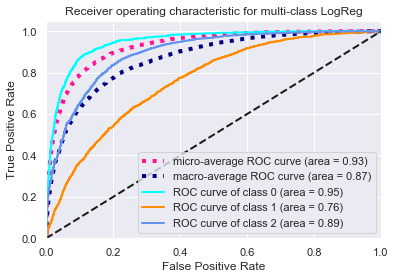

In [35]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class LogReg')
plt.legend(loc="lower right")
plt.show()

### Различные оценки auc -- площади под кривой

Смысла я в этом не вижу -- наверное, это надо сравнивать с такими же показателями для других моделей

In [36]:
X_test = tfidf.transform(X_test)
y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.867445 (macro),
0.883034 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.867445 (macro),
0.883034 (weighted by prevalence)
